In [1]:
#Julia v1.7+ is required; v1.9 is strongly recommended

using MKL #Speed up LinearAlgebra routines using Intel MKL BLAS instead of OpenBLAS

using StatsBase, Distributions
using LinearAlgebra
using Plots
using Yao, YaoPlots
#using CUDA, CuYao, YaoPlots # uncomment this line if you want to use the GPU routines

using JLD, ProgressMeter

In [2]:
#@show CUDA.version()
#@show CUDA.functional()
#@show CUDA.devices()
#@show CUDA.device()


In [3]:
function prepare_loss_gradient_approx(loss_func; stochastic_approx=false, stoch_shift_size_c=0.05, inplace=true)
    """
    Prepare a function that computes the gradient of a loss function using the parameter shift rule.
    
    Arguments:
    ==================
    loss_func :: Callable
        The loss function to be differentiated. The first argument of the loss function must be the parameter vector.
    stochastic_approx :: bool
        Whether to use the stochastic parameter shift rule (SPSA) or not.
    stoch_shift_size_c :: float
        The size of the random shift used in the stochastic parameter shift rule.
    inplace :: bool
        Whether to use the gradient should be changed in-place or not (vs. allocating and returning a new array).
    
    Returns:
    ==================
    loss_grad_func :: callable
        The function that computes the gradient of the loss function.
    """

    function inplace_loss_grad_func(loss_grad, eval_point, loss_func_args...)
        
        if !stochastic_approx #Non-stochastic parameter shift rule
            
            for input_dim in 1:length(eval_point)
                dim_basis_vec = zeros(length(eval_point))
                dim_basis_vec[input_dim] = 1.0
                loss_grad[input_dim] = (loss_func(eval_point .+ pi*dim_basis_vec/2, loss_func_args...) - loss_func(eval_point .- pi*dim_basis_vec/2, loss_func_args...)) / 2
            end
            
        else #SPSA
            random_shift_vec = sample([-1,1], length(eval_point); replace=true) #np.random.choice([-1,1],)
            loss_grad = (loss_func(eval_point .+ stoch_shift_size_c*random_shift_vec, loss_func_args...) - loss_func(eval_point .- stoch_shift_size_c*random_shift_vec, loss_func_args...)) ./ (2*stoch_shift_size_c*random_shift_vec)
        end
    end

    function loss_grad_func(eval_point, loss_func_args...)
        
        loss_grad = []

        if !stochastic_approx #Non-stochastic parameter shift rule
            for input_dim in 1:length(eval_point)
                dim_basis_vec = zeros(length(eval_point))
                dim_basis_vec[input_dim] = 1.0
                push!(loss_grad, (loss_func(eval_point .+ pi*dim_basis_vec/2, loss_func_args...) - loss_func(eval_point .- pi*dim_basis_vec/2, loss_func_args...)) / 2)
            end
        else #SPSA
            random_shift_vec = sample([-1,1], length(eval_point); replace=true) #np.random.choice([-1,1],)
            loss_grad = (loss_func(eval_point .+ stoch_shift_size_c*random_shift_vec, loss_func_args...) - loss_func(eval_point .- stoch_shift_size_c*random_shift_vec, loss_func_args...)) ./ (2*stoch_shift_size_c*random_shift_vec)
        end
        return loss_grad
    end


    if inplace
        return inplace_loss_grad_func
    else
        return loss_grad_func
    end
end

prepare_loss_gradient_approx (generic function with 1 method)

### The Meta-VQE

In [4]:
function processing_step_circuit(reg::ArrayReg, thetas::Vector)
    """
    Construct a circuit for a processing block of the PQC ansatz. This is a specific implementation for the 2-layer ansatz.

    Note: This method assumes 2 layers of processing layers and is designed for less computational overhead. 
    If you need a flexible / higher number of processing layers, use the more general method below.

    Arguments:
    ==================
    reg :: Yao.ArrayReg
        The qubit register to apply the circuit to.
    thetas :: Vector
        The vector of parameters to use in the circuit.

    Returns:
    ==================
    :: Yao.CompositeBlock
        The circuit for the processing block.
    """

    @assert length(thetas) == 2 * 2 * nqubits(reg) # 2 paramterized layers per qubit with 2 rotation gates each
    
    rz_thetas = thetas[1:2*nqubits(reg)]
    ry_thetas = thetas[2*nqubits(reg)+1:4*nqubits(reg)]
    
    #Variational Layer 1:
    var_lay_1 = chain(subroutine(nqubits(reg), kron(RotationGate(Z, rz_thetas[2*q_i-1]) for q_i in 1:nqubits(reg)), 1:nqubits(reg)), 
                    subroutine(nqubits(reg), kron(RotationGate(Y, ry_thetas[2*q_i-1]) for q_i in 1:nqubits(reg)), 1:nqubits(reg)))
    # Odd indices in the theta vectors are for the first variational layer
    
    # In-between Entangling Layer (odd control indices):
    entang_lay_1 = chain(nqubits(reg), cnot(q_i, q_i+1) for q_i in 1:2:nqubits(reg))

    #Variational Layer 2:
    var_lay_2 = chain(subroutine(nqubits(reg), kron(RotationGate(Z, rz_thetas[2*q_i]) for q_i in 1:nqubits(reg)), 1:nqubits(reg)), 
                    subroutine(nqubits(reg), kron(RotationGate(Y, ry_thetas[2*q_i]) for q_i in 1:nqubits(reg)), 1:nqubits(reg)))
    # Even indices in the theta vectors are for the second variational layer
    
    # Final Entangling Layer (even control indices):
    entang_lay_2 = chain(nqubits(reg), cnot(q_i, q_i+1) for q_i in 2:2:nqubits(reg)-1)

    return chain(var_lay_1, entang_lay_1, var_lay_2, entang_lay_2)
end

function processing_step_circuit(reg::ArrayReg, thetas::Vector, num_layers::Int)
    """
    Construct a circuit for a processing block of the PQC ansatz. This is a general implementation for any number of layers.
    
    Arguments:
    ==================
    reg :: Yao.ArrayReg
        The qubit register to apply the circuit to.
    thetas :: Vector
        The vector of parameters to use in the circuit.
    num_layers :: Int
        The number of layers to use in the processing block.
    
    Returns:
    ==================
    :: Yao.CompositeBlock
        The circuit for the processing block.
    """
    
    @assert length(thetas) == 2 * num_layers * nqubits(reg) # num_layers paramterized layers per qubit with 2 rotation gates each
    
    rz_thetas = thetas[1:num_layers*nqubits(reg)]
    ry_thetas = thetas[num_layers*nqubits(reg)+1:2*num_layers*nqubits(reg)]
    
    layers = []

    for lay_i in 1:num_layers
        #Variational Layer 1:
        var_lay = chain(subroutine(nqubits(reg), kron(RotationGate(Z, rz_thetas[num_layers*q_i-(lay_i % num_layers)]) for q_i in 1:nqubits(reg)), 1:nqubits(reg)), 
                        subroutine(nqubits(reg), kron(RotationGate(Y, ry_thetas[num_layers*q_i-(lay_i % num_layers)]) for q_i in 1:nqubits(reg)), 1:nqubits(reg)))
        push!(layers, var_lay)

        #Entangling Layer (alternating odd and even control indices):
        entang_lay = chain(nqubits(reg), cnot(q_i, q_i+1) for q_i in (2 - (lay_i % 2)):2:(nqubits(reg)+(lay_i % 2)-1))
        push!(layers, entang_lay)
    end
    return chain([layers]...)
end

processing_step_circuit (generic function with 2 methods)

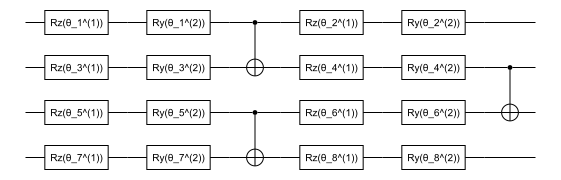

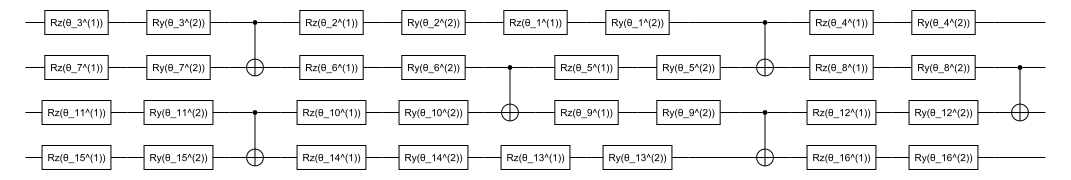

In [5]:
reg = zero_state(4)

theta_0 = [Symbol("θ_$i^($j)") for j in 1:2 for i in 1:2*nqubits(reg)]

circuit = processing_step_circuit(reg, theta_0)

display(YaoPlots.plot(circuit))

num_layers = 4
theta_0 = [Symbol("θ_$i^($j)") for j in 1:2 for i in 1:num_layers*nqubits(reg)]

circuit = processing_step_circuit(reg, theta_0, num_layers)
display(YaoPlots.plot(circuit))


In [6]:
function encoding_function(Delta::Union{Float64, Symbol}, phi::Vector)
    """
    Construct the encoding function for the PQC ansatz by recycling the processing block generator. 
    Note that this method assumes 2 layers of encoding layers and is designed for less computational overhead.
    
    Arguments:
    ==================
    Delta :: Float64 or Symbol
        The hamiltonian parameter Δ to use in the encoding function.
    phi :: Vector
        The vector of parameters to use in the encoding function.
    
    Returns:
    ==================
    :: Vector
        Concatened vector outputs of the encoding function for the Z and Y rotation parameters.
    """

    weights = phi[1:Int(floor(length(phi)/2))]
    biases = phi[Int(floor(length(phi)/2)) + 1:end]
    weights_z, weights_y = weights[1:Int(floor(length(weights)/2))], weights[Int(floor(length(weights)/2))+1:end]
    biases_z, biases_y = biases[1:Int(floor(length(biases)/2))], biases[Int(floor(length(biases)/2))+1:end]
    
    return cat((weights_z .* Delta) .+ biases_z, (weights_y .* Delta) .+ biases_y; dims=1)
end

function encoding_step_circuit(reg::ArrayReg, phi::Vector, Delta::Union{Float64, Symbol}, encoding_function::Base.Callable)
    """
    Construct a circuit for an encoding block of the PQC ansatz. 
    Note: This method assumes 2 layers of encoding layers and is designed for less computational overhead.
    If you need a flexible / higher number of encoding layers, use the more general method below.

    Arguments:
    ==================
    reg :: Yao.ArrayReg
        The qubit register to apply the circuit to.
    phi :: Vector
        The vector of parameters to use in the circuit.
    Delta :: Float64 or Symbol
        The hamiltonian parameter Δ to use in the encoding function.
    encoding_function :: Callable
        The encoding function to use to compute the encoding circuit parameters.

    Returns:
    ==================
    :: Yao.CompositeBlock
        The circuit for the encoding block.
    """
    @assert length(phi) == 2 * 2 * 2 * nqubits(reg) # 2 paramterized layers per qubit with 2 fun
    
    return processing_step_circuit(reg, encoding_function(Delta, phi))
end

function encoding_step_circuit(reg::ArrayReg, phi::Vector, Delta::Union{Float64, Symbol}, encoding_function::Base.Callable, num_layers::Int)
    """
    Construct a circuit for an encoding block of the PQC ansatz. This is a general implementation for any number of layers.
    
    Arguments:
    ==================
    reg :: Yao.ArrayReg
        The qubit register to apply the circuit to.
    phi :: Vector
        The vector of parameters to use in the circuit.
    Delta :: Float64 or Symbol
        The hamiltonian parameter Δ to use in the encoding function.
    encoding_function :: Callable
        The encoding function to use in the circuit.
    num_layers :: Int
        The number of layers to use in the encoding block
    
    Returns:
    ==================
    :: Yao.CompositeBlock
        The circuit for the encoding block.
    """

    @assert length(phi) == 2 * 2 * num_layers * nqubits(reg) # 2 paramterized layers per qubit with 2 fun
    
    return processing_step_circuit(reg, encoding_function(Delta, phi), num_layers)
end

encoding_step_circuit (generic function with 2 methods)

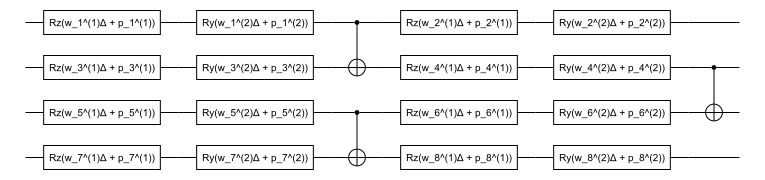

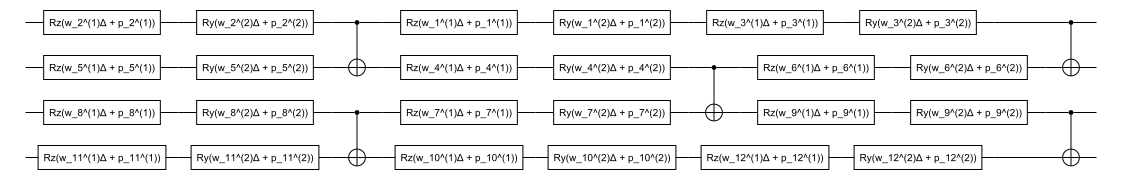

In [7]:

reg = zero_state(4)


Base.:*(x::Symbol, y::Symbol) = Symbol("$(x)$(y)")
Base.:+(x::Symbol, y::Symbol) = Symbol("$(x) + $(y)")

phi_0 = [Symbol("$(phi_type)_$i^($j)") for phi_type in ["w", "p"] for j in 1:2 for i in 1:2*nqubits(reg)]

circuit = encoding_step_circuit(reg, phi_0, Symbol("Δ") ,encoding_function)
display(YaoPlots.plot(circuit))

num_layers = 3
phi_0 = [Symbol("$(phi_type)_$i^($j)") for phi_type in ["w", "p"] for j in 1:2 for i in 1:num_layers*nqubits(reg)]

circuit = encoding_step_circuit(reg, phi_0, Symbol("Δ") ,encoding_function, num_layers)

display(YaoPlots.plot(circuit))

In [8]:

function xxz_chain_hamiltonian_1D(reg::ArrayReg, hamilt_params::Dict)
    """
    Returns a tuple of generators for every hamiltonian term in the XXZ chain hamiltonian
    such that each inidivdual term is given as (coefficient, gate set generator)

    Arguments:
    ==================
    reg :: Yao.ArrayReg
        The qubit register to apply the circuit to.
    hamilt_params :: Dict
        The dictionary of hamiltonian parameters to use in the hamiltonian.
    
    Returns:
    ==================
    :: Tuple{Tuple{Float64, Yao.CompositeBlock}}
        A tuple of tuples (term coefficient, term gate set) for every hamiltonian term in the XXZ chain hamiltonian.
    """

    #Return a generator for each term in the hamiltonian. Shouldn't be in one circuit!
    x_interact_term = (repeat(nqubits(reg), X, (q_i, q_i % nqubits(reg) + 1)) for q_i in 1:nqubits(reg))
    #for q_i, _ in enumerate(reg)
    #cirq.X(reg[q_i]) * cirq.X(reg[(q_i+1) % length(reg)])

    y_interact_term = (repeat(nqubits(reg), Y, (q_i, q_i % nqubits(reg) + 1)) for q_i in 1:nqubits(reg))
    #for q_i, _ in enumerate(reg):
    #cirq.Y(reg[q_i]) * cirq.Y(reg[(q_i+1) % length(reg)])
    
    z_interact_term = (repeat(nqubits(reg), Z, (q_i, q_i % nqubits(reg) + 1)) for q_i in 1:nqubits(reg))
    #for q_i, _ in enumerate(reg):
    #cirq.Z(reg[q_i]) * cirq.Z(reg[(q_i+1) % length(reg)])
    
    z_align_term = (put(nqubits(reg), q_i=>Z) for q_i in 1:nqubits(reg))
    #for q_i, _ in enumerate(reg):
    #yield cirq.Z(reg[q_i])

    return (1.0, x_interact_term), (1.0, y_interact_term),  (hamilt_params[:Delta],z_interact_term), (hamilt_params[:Delta], z_align_term)
end


function get_XXZ_hamiltonian_measurement_basis_change(reg::ArrayReg, hamilt_params::Dict)
    """
    Returns a tuple of generators for the measurement basis change gates of every hamiltonian term in the XXZ chain hamiltonian
    such that each inidivdual term is given as (coefficient, basis change gateset generator)

    Arguments:
    ==================
    reg :: Yao.ArrayReg
        The qubit register to apply the circuit to.
    hamilt_params :: Dict
        The dictionary of hamiltonian parameters to use in the hamiltonian.
    
    Returns:
    ==================
    :: Tuple{Tuple{Float64, Yao.CompositeBlock}}
        A tuple of tuples (term coefficient, term basis change gateset) for every hamiltonian term in the XXZ chain hamiltonian.
    """

    term_tuples = xxz_chain_hamiltonian_1D(reg, hamilt_params)
    
    map(term_tuples) do (term_coeff, term_generator) #Map each pauli-string term in the hamiltonian to its measuremenet basis change

        measured_strings = [] # list of pauli operator objects
        term_measurement_gateset = []
        measured_qubits = []
        
        for pauli_str in term_generator #Note: Pauli_str is a subroutine struct
            push!(measured_strings, pauli_str)
            ops = typeof(pauli_str.content) == Yao.KronBlock ? pauli_str.content.blocks : fill(pauli_str.content, nqubits(reg))
            for (qubit, operator) in zip(pauli_str.locs, ops)
                if operator == X && !(qubit in measured_qubits)
                    push!(term_measurement_gateset, put(nqubits(reg), qubit=>H))
                    push!(measured_qubits, qubit)
                elseif operator == Y && !(qubit in measured_qubits)
                    push!(term_measurement_gateset, chain(put(nqubits(reg), qubit=>shift(pi/2)'), put(nqubits(reg), qubit=>H))) #Note the conjugation by "'"!
                    push!(measured_qubits, qubit)
                end
            end
        end

        
        return ((term_coeff, measured_strings), chain(nqubits(reg), term_measurement_gateset))
    end

end


function meas_hamilt_expectation(reg::ArrayReg, circuit_params::Vector; hamilt_params::Dict, n_meas_reps::Int)
    """
    Returns the expectation value of the hamiltonian given by hamilt_params for the state generated by the circuit given through circuit_params
    This is the non-cheating variant, i.e. the expectation value is calculated by repeated measurements on the circuit output state; involving sampling noise.

    Arguments:
    ==================
    reg :: Yao.ArrayReg
        The qubit register to apply the circuit to.
    circuit_params :: Vector
        The vector of circuit parameters to use in the circuit.
    hamilt_params :: Dict
        The dictionary of hamiltonian parameters to use in the hamiltonian.
    n_meas_reps :: Int
        The number of times to measure the circuit output state to calculate the expectation value.
    
    Returns:
    ==================
    energy_expect :: Float64
        The expectation value of the hamiltonian given by hamilt_params for the state generated by the circuit given through circuit_params
    """
    
    energy_expect = 0.0

    encoding_step = encoding_step_circuit(reg, circuit_params[1:Int(8*nqubits(reg))], hamilt_params[:Delta] ,encoding_function)
    processing_step = processing_step_circuit(reg, circuit_params[Int(8*nqubits(reg))+1:end])

    pqc_circuit = chain(nqubits(reg), encoding_step, processing_step)
    #pqc_circuit = simplify(pqc_circuit)

    #Iterate over terms with commuting pauli strings in the hamiltonian
    for (measured_term, term_basis_change_gates) in get_XXZ_hamiltonian_measurement_basis_change(reg, hamilt_params)
        
        term_coeff, measured_strings = measured_term

        #Prepare, run and measure the circuit      

        term_meas_circuit = chain(nqubits(reg), pqc_circuit, term_basis_change_gates)
        #term_meas_circuit = chain(nqubits(reg), repeat(nqubits(reg), H, 1:nqubits(reg)), term_basis_change_gates)
        
        #display(YaoPlots.plot(term_basis_change_gates))
        #display(YaoPlots.plot(term_meas_circuit))

        proxy_reg = zero_state(nqubits(reg))
        apply!(proxy_reg, term_meas_circuit)
        
        meas_outputs = measure(ComputationalBasis(), proxy_reg, 1:nqubits(reg); nshots=n_meas_reps) #For direct measurement, comment out when using the measurement gates. `ResetTo`
        #@show meas_outputs
        hist = StatsBase.fit(Histogram, convert.(Int, meas_outputs), 0:2^nqubits(reg))
        #@show meas_outputs

        non_zero_weights = findall(!iszero, hist.weights)
        meas_outcomes_hist = zip(hist.weights[non_zero_weights], reverse.(digits.(non_zero_weights.-1, base=2, pad=nqubits(reg))))

        #print("Finished term measurements: ", meas_outcomes_hist)
        
        term_expect = 0.0
        for pauli_str in measured_strings
            pauli_str_expect = 0.0
            for (count, meas_outcomes) in meas_outcomes_hist
                
                pauli_str_eigval = prod([1 - 2 * meas_outcomes[q_i] for q_i in pauli_str.locs])
                pauli_str_expect += pauli_str_eigval * count / n_meas_reps
            end
            term_expect += pauli_str_expect
        end
        energy_expect += term_coeff * term_expect
    end
    return energy_expect
end

function direct_hamilt_expectation(reg::ArrayReg, circuit_params::Vector; hamilt_params::Dict)
    """
    Returns the expectation value of the hamiltonian given by hamilt_params for the state generated by the circuit given through circuit_params
    This is the cheating variant, i.e. the expectation value is calculated by directly computing the expectation value of the hamiltonian on the state vector using their matrix representation; without sampling noise.
    
    Arguments:
    ==================
    reg :: Yao.ArrayReg
        The qubit register to apply the circuit to.
    circuit_params :: Vector
        The vector of circuit parameters to use in the circuit.
    hamilt_params :: Dict
        The dictionary of hamiltonian parameters to use in the hamiltonian.
    
    Returns:
    ==================
    energy_expect :: Float64
        The expectation value of the hamiltonian given by hamilt_params for the state generated by the circuit given through circuit_params
    """
    
    energy_expect = 0.0

    #Prepare, run and measure the circuit
    encoding_step = encoding_step_circuit(reg, circuit_params[1:Int(8*nqubits(reg))], hamilt_params[:Delta] ,encoding_function)
    processing_step = processing_step_circuit(reg, circuit_params[Int(8*nqubits(reg))+1:end])

    pqc_circuit = chain(nqubits(reg), encoding_step, processing_step)

    #Iterate over terms with commuting pauli strings in the hamiltonian
    for (measured_term, term_basis_change_gates) in get_XXZ_hamiltonian_measurement_basis_change(reg, hamilt_params)
        
        term_coeff, measured_strings = measured_term

        
        # ----- Indirect way of computing the expectation value -------
        proxy_reg = zero_state(nqubits(reg))
    
        expval(state) = real(sum([dot(state, mat(pauli_str), state) for pauli_str in measured_strings]))
        #expval(state) = real(sum([adjoint(state) * mat(pauli_str) * state for pauli_str in measured_strings]))
        

        apply!(proxy_reg, pqc_circuit)
        normalize!(proxy_reg)
        
        #print("Term energy expect: ",expval(fin_state_vec), " for state vector: ", fin_state_vec)
        energy_expect += term_coeff* expval(state(proxy_reg))
        

        #----Direct alternative------
        #energy_expect += term_coeff*real(sum([expect(pauli_str, zero_state(nqubits(reg)) => pqc_circuit) for pauli_str in measured_strings]))
        #----------------------------

    end
    energy_expect 

    return energy_expect
end

"""####### GPU versions of direct_hamilt_expectation and exact_hamilt_GS_energy #######
using CUDA, CuYao, Adapt

function direct_hamilt_expectation_gpu(reg::ArrayReg, circuit_params::Vector; hamilt_params::Dict)


    energy_expect = 0.0

    #Prepare, run and measure the circuit
    encoding_step = encoding_step_circuit(reg, circuit_params[1:Int(8*nqubits(reg))], hamilt_params[:Delta] ,encoding_function)
    processing_step = processing_step_circuit(reg, circuit_params[Int(8*nqubits(reg))+1:end])

    pqc_circuit = chain(nqubits(reg), encoding_step, processing_step)

    #Iterate over terms with commuting pauli strings in the hamiltonian
    for (measured_term, term_basis_change_gates) in get_XXZ_hamiltonian_measurement_basis_change(reg, hamilt_params)
        
        term_coeff, measured_strings = measured_term

        # ----- Indirect way of computing the expectation value -------
        proxy_reg = cuzero_state(nqubits(reg)) #|> CuYao.cu
    
        expval(state) = [float(CUBLAS.dot(state, CuArray(mat(pauli_str)), state)) for pauli_str in measured_strings] |> sum |> real
        #expval(state) = real(sum([adjoint(state) * mat(pauli_str) * state for pauli_str in measured_strings]))

        apply!(proxy_reg, pqc_circuit)
        normalize!(proxy_reg)
        
        #print("Term energy expect: ",expval(fin_state_vec), " for state vector: ", fin_state_vec)
        energy_expect += term_coeff*expval(state(proxy_reg))

        #----Direct alternative------
        #energy_expect += term_coeff*real(sum([expect(pauli_str, zero_state(nqubits(reg)) => pqc_circuit) for pauli_str in measured_strings]))
        #----------------------------

    end
    energy_expect 

    return energy_expect
end

function exact_hamilt_GS_energy_gpu(reg::ArrayReg, hamilt_params::Dict)

    hamilt_matrix = zeros((2^nqubits(reg), 2^nqubits(reg)))
    
    term_tuples = xxz_chain_hamiltonian_1D(reg, hamilt_params)
    for (term_coeff, term_generator) in term_tuples
        for pauli_str in term_generator
            hamilt_matrix .+= term_coeff*mat(pauli_str)
        end
    end

    #gs_energy = Missing
    #try
        gs_energy = CUBLAS.eigmin(hamilt_matrix)
    #catch #When the matrix has slight imaginary parts, the eigenvalues are complex and can't be
    #    CUDA.reclaim()
    #    sleep(10)
    #    eig_vals = Vector(CUBLAS.eigvals(CuArray(hamilt_matrix)))
    #    gs_energy = minimum(real.(eig_vals))
    #end
    #eigvals = eigen(hamilt_matrix).values
    #gs_energy = minimum(eigvals)
    
    return gs_energy
end
"""

function exact_hamilt_GS_energy(reg::ArrayReg, hamilt_params::Dict)
    """
    Returns the ground state energy of the hamiltonian given by hamilt_params from the exact and explicit diagonalization of the hamiltonian matrix

    Arguments:
    ==================
    reg :: ArrayReg
        The register on which the hamiltonian acts
    hamilt_params :: Dict
        The parameters of the hamiltonian
    
    Returns:
    ==================
    gs_energy :: Float64
        The ground state energy of the hamiltonian
    """

    hamilt_matrix = zeros(ComplexF64, (2^nqubits(reg), 2^nqubits(reg)))
    
    term_tuples = xxz_chain_hamiltonian_1D(reg, hamilt_params)
    for (term_coeff, term_generator) in term_tuples
        for pauli_str in term_generator
            hamilt_matrix .+= term_coeff*mat(pauli_str)
        end
    end

    gs_energy = Missing
    try
        gs_energy = eigmin(hamilt_matrix)
    catch #When the matrix has slight imaginary parts, the eigenvalues are complex and can't be
        gs_energy = minimum(real.(eigvals(hamilt_matrix)))
    end
    #eigvals = eigen(hamilt_matrix).values
    #gs_energy = minimum(eigvals)
    
    return gs_energy
end

exact_hamilt_GS_energy (generic function with 1 method)

In [9]:
output = ["1011000","0000100","0101101","1110111"]
print(output)
nq = 7
begin
	hist = StatsBase.fit(Histogram, parse.(Int, output; base=2), 0:2^nq)
    non_zero_weights = findall(!iszero, hist.weights)
	o1 = hist.weights[non_zero_weights]
	@time o2 = string.(0:(2^nq-1), base=2, pad=nq)[non_zero_weights]
	@time o3 = reverse.(digits.(0:(2^nq-1), base=2, pad=nq)[non_zero_weights])
    @time o4 = reverse.(digits.(non_zero_weights.-1, base=2, pad=nq))
    @show o1 
    @show o2
    @show o3 
    @show o4
end


["1011000", "0000100", "0101101", "1110111"

]  0.053784 seconds (97.04 k allocations: 6.581 MiB, 99.24% compilation time)


  0.156622 seconds (224.64 k allocations: 15.229 MiB, 95.77% compilation time)
  0.076659 seconds (144.85 k allocations: 9.637 MiB, 98.42% compilation time)


o1 = [1, 1, 1, 1]
o2 = ["0000100", "0101101", "1011000", "1110111"]


o3 = [[0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 1, 1, 0, 1], [1, 0, 1, 1, 0, 0, 0], [1, 1, 1, 0, 1, 1, 1]]
o4 = [[0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 1, 1, 0, 1], [1, 0, 1, 1, 0, 0, 0], [1, 1, 1, 0, 1, 1, 1]]


4-element Vector{Vector{Int64}}:
 [0, 0, 0, 0, 1, 0, 0]
 [0, 1, 0, 1, 1, 0, 1]
 [1, 0, 1, 1, 0, 0, 0]
 [1, 1, 1, 0, 1, 1, 1]

In [10]:
#YaoPlots.CircuitStyles.paramtextsize[] = Measures.AbsoluteLength(3)
#YaoPlots.CircuitStyles.r[] = Measures.AbsoluteLength(0.2)

reg = zero_state(4)

hamilt_params = Dict()
hamilt_params[:Delta] = 2.0  # Transverse field strength
hamilt_params[:lambda] = 2.0 # Anisotropy parameter

println("############ Direct Hamiltonian Circuits ############")

for (term_coeff, term_generator) in xxz_chain_hamiltonian_1D(reg, hamilt_params)
    println("\nThe following term has coefficient", term_coeff, "\n")
    circuit = chain(nqubits(reg), term_generator...)
    #println(circuit, reg)
end

println("\n############ Measurement Basis Change Circuits ############")

for (measured_term, term_basis_change_gates) in get_XXZ_hamiltonian_measurement_basis_change(reg, hamilt_params)
    term_coeff, measured_strings = measured_term
    println("\nThe following term has coefficient", term_coeff, "\n")
    circuit =  chain(nqubits(reg), term_basis_change_gates, Yao.Measure(nqubits(reg); locs=1:nqubits(reg), operator=ComputationalBasis()))
    #display(YaoPlots.plot(circuit))
end

############ Direct Hamiltonian Circuits ############

The following term has coefficient1.0




The following term has coefficient1.0




The following term has coefficient2.0




The following term has coefficient2.0


############ Measurement Basis Change Circuits ############



The following term has coefficient1.0


The following term has coefficient1.0


The following term has coefficient2.0


The following term has coefficient2.0



In [11]:

reg = zero_state(12)

hamilt_params = Dict()
hamilt_params[:Delta] = 0.5  # Transverse field strength
hamilt_params[:lambda] = 0.75 # Anisotropy parameter

#exact_hamilt_GS_energy(reg, hamilt_params)
#-21.4189592632828 // ~8 min vs. 2.5 min with MKL
exact_hamilt_GS_energy(reg, hamilt_params)


-18.322757688943646

In [12]:
#srand(123)
reg = zero_state(10)

hamilt_params = Dict()
hamilt_params[:Delta] = 1.0  # Transverse field strength
hamilt_params[:lambda] = 0.2 # Anisotropy parameter

init_phi_params = rand(Normal(0, pi/2), 8*nqubits(reg))
init_theta_params = rand(Normal(0, pi/2), 4*nqubits(reg))
init_circuit_params = cat(init_phi_params, init_theta_params; dims=1)

@time println(meas_hamilt_expectation(reg, init_circuit_params; hamilt_params=hamilt_params, n_meas_reps=1000))
@time println(direct_hamilt_expectation(reg, init_circuit_params; hamilt_params=hamilt_params))
# -1.8513053721186117 // 3.611728 seconds (5.89 M allocations: 383.844 MiB, 3.20% gc time, 99.68% compilation time)

1.3060000000000003
  4.461390 seconds (7.28 M allocations: 467.689 MiB, 4.46% gc time, 99.23% compilation time)


1.04977138737531
  0.548290 seconds (778.68 k allocations: 54.756 MiB, 3.32% gc time, 98.50% compilation time)


### Construct training set of hamiltonian expectation values


In [13]:

function construct_training_set(train_set_size::Int, min_hamilt_params::Dict{Symbol, Float64}, max_hamilt_params::Dict{Symbol, Float64}, mode::Symbol)
    """
    Constructs a training set of hamiltonian parameters.

    Arguments:
    ==================
    train_set_size :: Int
        The number of samples in the training set
    min_hamilt_params :: Dict{Symbol, Float64}
        The minimum values of the hamiltonian parameters
    max_hamilt_params :: Dict{Symbol, Float64}
        The maximum values of the hamiltonian parameters
    mode :: Symbol
        The sampling mode. Can be :equidistant or :uniform_random.

    Returns:
    ==================
    training_set :: Vector{Dict{Symbol, Float64}}
        The training set of hamiltonian parameters
    """
    
    @assert keys(min_hamilt_params) == keys(max_hamilt_params)

    training_set = []
    for i in 1:train_set_size
        sample_i = Dict()
        for param in keys(min_hamilt_params)
            if mode == :equidistant
                sample_i[param] = min_hamilt_params[param] + i*(max_hamilt_params[param] - min_hamilt_params[param])/(train_set_size-1)
            elseif mode == :uniform_random
                if min_hamilt_params[param] == max_hamilt_params[param]
                    sample_i[param] = min_hamilt_params[param]
                else
                    sample_i[param] = rand(Uniform(min_hamilt_params[param], max_hamilt_params[param]))
                end
            end
        end
        push!(training_set, sample_i)
    end
    return training_set
end

function construct_test_set(test_set_size::Int, min_hamilt_params::Dict{Symbol, Float64}, max_hamilt_params::Dict{Symbol, Float64}, mode::Symbol)
    """
    Constructs a test set of hamiltonian parameters.
    
    Arguments:
    ==================
    test_set_size :: Int
        The number of samples in the test set
    min_hamilt_params :: Dict{Symbol, Float64}
        The minimum values of the hamiltonian parameters
    max_hamilt_params :: Dict{Symbol, Float64}
        The maximum values of the hamiltonian parameters
    mode :: Symbol
        The sampling mode. Can be :equidistant or :uniform_random.
    
    Returns:
    ==================
    :: Vector{{Dict{Symbol, Float64}}}
        The test set of hamiltonian parameters
    """

    return construct_training_set(test_set_size, min_hamilt_params, max_hamilt_params, mode)
end



construct_test_set (generic function with 1 method)

In [14]:

train_set_size = 10
min_hamilt_params = Dict(:lambda => 0.75, :Delta => -1.1)
max_hamilt_params = Dict(:lambda => 0.75, :Delta => 1.1)

println(construct_training_set(train_set_size, min_hamilt_params, max_hamilt_params, :equidistant))

Any[

Dict{Any, Any}

(:lambda => 0.75, :Delta => -0.8555555555555556), Dict{Any, Any}(:lambda => 0.75, :Delta => -0.6111111111111112), Dict{Any, Any}(:lambda => 0.75, :Delta => -0.3666666666666667), Dict{Any, Any}(:lambda => 0.75, :Delta => -0.12222222222222223), Dict{Any, Any}(:lambda => 0.75, :Delta => 0.12222222222222223), Dict{Any, Any}(:lambda => 0.75, :Delta => 0.3666666666666667), Dict{Any, Any}(:lambda => 0.75, :Delta => 0.6111111111111112), Dict{Any, Any}(:lambda => 0.75, :Delta => 0.8555555555555556), Dict{Any, Any}(:lambda => 0.75, :Delta => 1.1), Dict{Any, Any}(:lambda => 0.75, :Delta => 1.3444444444444446)]


In [15]:
function initialize_circuit_params(reg::ArrayReg, params_init_mode::Symbol=:normal_random)
    """
    Generates the initial parameters of the PQC.

    Arguments:
    ==================
    reg :: Yao.ArrayReg
        The qubit register
    params_init_mode :: Symbol
        The mode of the parameters initialization. Can be :zero or :normal_random.
    
    Returns:
    ==================
    init_circuit_params :: Vector{Float64}
        The initial parameters of the PQC
    """
    
    if params_init_mode == :zero
        init_phi_params = zeros(8*nqubits(reg))
        init_theta_params = zeros(4*nqubits(reg))
        init_circuit_params = cat(init_phi_params, init_theta_params; dims=1)
        return init_circuit_params
    elseif params_init_mode == :normal_random
        init_phi_params = rand(Normal(0.0, 0.02), 8*nqubits(reg))
        init_theta_params = rand(Normal(0.0, 0.02), 4*nqubits(reg))
        init_circuit_params = cat(init_phi_params, init_theta_params; dims=1)
        return init_circuit_params
    end
end

initialize_circuit_params (generic function with 2 methods)

In [16]:

using Optimization, Zygote, OptimizationOptimisers, OptimizationNLopt, OptimizationMultistartOptimization #,OptimizationEvolutionary, OptimizationGCMAES, OptimizationNOMAD, OptimizationBBO, Zygote

function meta_vqe_energy_loss(circuit_params::Vector, loss_params::Tuple{ArrayReg, Vector, Int})
    """
    Returns the meta-VQE energy loss for a given set of parameters.
    The used loss fucntion is simply the sum of the expectation values of the hamiltonian over the training set of hamiltonian parameters.
    
    Arguments:
    ==================
    circuit_params :: Vector{Float64}
        The parameters of the PQC
    loss_params :: Tuple{Yao.ArrayReg, Vector, Int}
        The loss parameters. The first element is the qubit register, the second element is the training set of hamiltonian parameters, the third element is the number of measurement repetitions.
        If measurement repetitions is set to -1, then the expectation value is directly calculated without sampling noise.
    
    Returns:
    ==================
    :: Float64
        The relative energy loss
    """

    reg, hamilt_params_training_set, n_meas_reps = loss_params

    if n_meas_reps == -1    
        return sum(direct_hamilt_expectation(reg, circuit_params, hamilt_params=hamilt_params_sample) for hamilt_params_sample in hamilt_params_training_set)
    else
        return sum(meas_hamilt_expectation(reg, circuit_params, hamilt_params=hamilt_params_sample, n_meas_reps=n_meas_reps) for hamilt_params_sample in hamilt_params_training_set)
    end
end

function train_meta_vqe(reg::ArrayReg, hamilt_params_training_set::Vector, init_circuit_params::Union{Array, Missing}=missing; params_init_mode::Symbol=:normal_random, n_meas_reps::Int)
    """
    Trains the meta-VQE circuit on a given training set of hamiltonian parameters.

    Arguments:
    ==================
    reg :: Yao.ArrayReg
        The qubit register
    hamilt_params_training_set :: Vector{Dict{Symbol, Float64}}
        The training set of hamiltonian parameters
    init_circuit_params :: Array or Missing
        The initial parameters of the PQC. If missing, then the parameters are initialized using the function initialize_circuit_params.
    params_init_mode :: Symbol
        The mode of the parameters initialization. Can be :zero or :normal_random.
    n_meas_reps :: Int
        The number of measurement repetitions. If set to -1, then the expectation value is directly calculated without sampling noise.
    
    Returns:
    ==================
    :: Vector
        The optimized PQC parameters
    loss_trace :: Vector
        The loss value at each optimization step
    """

    if ismissing(init_circuit_params)
        init_circuit_params = initialize_circuit_params(reg, params_init_mode)
    end
    @show init_circuit_params
    
    
    loss_target = missing
    try
        exact_energies = JLD.load("./exact_energies_q$(nqubits(reg))_train.jld")["exact_energies"]
        println("Exact energies imported from cache!")
        loss_target = sum(exact_energies)
        println("Train loss should converge to ", loss_target)
    catch
        println("No exact energies found for this config; Recomputing and caching...")
        exact_energies = []
        @showprogress for i in 1:length(hamilt_params_training_set)
            push!(exact_energies, exact_hamilt_GS_energy(reg, hamilt_params_training_set[i]))
        end
        JLD.save("./exact_energies_q$(nqubits(reg))_train.jld", "exact_energies",exact_energies)
        loss_target = sum(exact_energies)
        println("Train loss should converge to ", loss_target)   
    end
    
    

    #--------Set-up logging / callback routines -----------------
    loss_trace = []
    function callbackF(pqc_params, loss_val, kwargs...)
        push!(loss_trace, loss_val)
        return false
    end
    
    #-------------------------------------------------

    println("Setting up optimization problem...")
    loss_args = (reg, hamilt_params_training_set, n_meas_reps) # Equals p in Optimization.jl
    meta_vqe_loss_grad_fun = prepare_loss_gradient_approx(meta_vqe_energy_loss; stochastic_approx=false, stoch_shift_size_c=0.01, inplace=true)
    
    optim_func = OptimizationFunction(meta_vqe_energy_loss, 
                                     #Optimization.AutoZygote(), #Or NoAD() when using a custom Grad
                                     grad = meta_vqe_loss_grad_fun, 
                                     #cons=cons, #Optional constraints
                                     )

    lb = fill(-float(pi), length(init_circuit_params)) #Lower bounds on optimization parameters
    ub = fill(float(pi), length(init_circuit_params)) #Upper bounds on optimization parameters

    #We start with the exploration phase; gradient-free:
    println("Starting explorative training...")
    
    expl_problem = OptimizationProblem(optim_func, 
                                init_circuit_params, 
                                loss_args,
                                lb = lb,
                                ub = ub,
                                )

    
    expl_result = solve(expl_problem, 
                        NLopt.LN_COBYLA(),#Evolutionary.CMAES(μ=10, λ=1000, sigma0=1.0), #BBO_probabilistic_descent(),#NOMADOpt(), #QuadDirect(),#AdamW(0.06),
                        #splits=Tuple([[-float(pi), 0, float(pi)] for _ in 1:length(init_circuit_params)]),
                        maxiters = 8000,
                        #abstol = 1e-2,
                        xtol_rel=0.01,
                        progress = true,
                        callback = callbackF, #(params, loss_val, other_args returned from loss) -> return Boolean (stop or not)
                        )
   
    @show expl_result
    println("Finished exploration within $(expl_result.solve_time) s using $(expl_result.alg), reaching a loss of $(expl_result.objective)")
    println(expl_result.stats)
    println("Optimum at:", expl_result.u)
    println(expl_result.original) #Summary of the backend solver

    
    #We now start the fine-tuning phase; gradient-based:
    println("Starting fine-tuning...")
    optim_problem = OptimizationProblem(optim_func, 
                                        expl_result.u, 
                                        loss_args,
                                        #lb = lb,
                                        #ub = ub,
                                        )

    optim_result = solve(optim_problem, 
                        AdamW(0.06), #,#GCMAESOpt(),
                        maxiters = 300,
                        reltol = 1e-3,
                        #σ0 = 0.6,
                        progress = true,
                        callback = callbackF, #(params, loss_val, other_args returned from loss) -> return Boolean (stop or not)
                        )
       
    @show expl_result
    println("Finished fine-tuned optimization within $(optim_result.solve_time) s using $(optim_result.alg), reaching a loss of $(optim_result.objective)")
    println(optim_result.stats)
    println("Optimum at:", optim_result.u)
    println(optim_result.original) #Summary of the backend solver

    return optim_result.u, loss_trace
    
end

function evaluate_meta_vqe(reg::ArrayReg, circuit_params::Vector, hamilt_params_test_set::Vector, n_meas_reps::Int, out_filepath::String)
    """
    Evaluate energy expectation values of an meta-VQE optimized circuit on a test set of Hamiltonian parameters.

    Parameters:
    ==================
    reg :: Yao.ArrayReg
        The qubit register on which the circuit is defined.
    circuit_params :: Vector
        The optimized PQC parameters
    hamilt_params_test_set :: Vector
        The test set of Hamiltonian parameters
    n_meas_reps :: Int
        The number of measurement repetitions to use for the energy expectation value estimation
    out_filepath :: String
        The filepath to which the results are written. Must have the .jld extension.
    
    Returns:
    ==================
    energy_expectations :: Vector
        The energy expectation values for each Hamiltonian parameter set in the test set.
    """

    #Evaluate meta-VQE on test set:
    energy_expectations = []

    #Infere on test set:
    jldopen(out_filepath, "w") do file
        write(file, "hamilt_params_set", hamilt_params_test_set)

        @showprogress for hamilt_params_sample in hamilt_params_test_set
            params_group = JLD.create_group(file, "Delta_$(hamilt_params_sample[:Delta])_lambda_$(hamilt_params_sample[:lambda])")
            
            sample_energy_expect = missing
            if n_meas_reps == -1
                sample_energy_expect = direct_hamilt_expectation(reg, circuit_params, hamilt_params=hamilt_params_sample)
            else
                sample_energy_expect = meas_hamilt_expectation(reg, circuit_params, hamilt_params=hamilt_params_sample, n_meas_reps=n_meas_reps)
            end
            push!(energy_expectations, sample_energy_expect)
            
            params_group["energy_expectation"] = sample_energy_expect
            params_group["optim_circuit_params"] = circuit_params
        end
    end
    return energy_expectations
end


evaluate_meta_vqe (generic function with 1 method)

In [17]:
reg = zero_state(10)

train_set_size = 10
min_hamilt_params = Dict(:lambda => 0.75, :Delta => -1.1)
max_hamilt_params = Dict(:lambda => 0.75, :Delta => 1.1)

train_set = construct_training_set(train_set_size, min_hamilt_params, max_hamilt_params, :equidistant)
test_set = construct_test_set(100, min_hamilt_params, max_hamilt_params, :equidistant)

out = -1

-1

Note: Running everything above this cell is safe in that it neither deletes/creates files or starts long + intense computation/optimization loops. Be carefull in what you run further below!

In [19]:


opt_circuit_params, loss_trace = train_meta_vqe(reg, train_set; params_init_mode=:normal_random, n_meas_reps=1000)

save("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_optim_circuit_params_s1000.jld", "opt_circuit_params", opt_circuit_params,"loss_trace", loss_trace, "training_set", train_set)


init_circuit_params = [-0.002721745326545752, -0.00983190907463296, 0.009582446848844458, 0.014051719775820188, -0.001941993140317034, 0.0045950637676869435, 0.013993662280010033, 0.006671355603593699, 0.008698737566284896, -0.00805708759206383, 0.02552428640025361, -0.004782970249364292, 0.018469449620947445, 0.004939945117577392, 0.000504012793131114, -0.007846512435599546, -0.0388954013412037, 0.015194667693335039, 0.020248038636805944, -0.006693953352796739, 0.031027746377289295, -0.020128625028774296, 0.008140533485431912, 0.016322506332386817, 0.02729229825531186, -0.011903470870528753, 0.0033137571884990476, -0.00771546117328365, -0.039451117906236545, 0.021452682933171218, -0.00464801501249865, -0.013122308687756584, -0.00909930990990073, -0.005927964002703193, 0.021070602503728685, 0.0036527347976051893, 0.012734378161785716, -0.002498154074063668, 0.011838048798983133, -0.010572864803216874, -0.015283948968004257, 0.02251100989886774, 0.0033672935382742957, 0.0148311977611572


expl_result = retcode: MaxIters
u: [1.996829495882227, 0.066362413193211, -0.48263195254504926, -0.2310968539732093, 0.3240311496998967, -0.7329737761601565, -0.7407706910625617, 0.07019812358242172, 0.001621025875324109, 0.35015980741210095, 1.8515134960865414, 0.1513644335016532, 0.6345620437719124, 0.09561583059916648, 0.5939205756597356, -0.2516247646415432, 1.4889554945079704, 0.5303410162906819, -0.701547059163138, 0.26762319361164355, 1.6201323176470326, 1.6887632142248263, 1.465022352112725, 0.05217104468133977, 1.9771071194227783, 0.3733981506409306, 0.15304604565987923, 0.35072766612370865, 0.9001208106970948, 0.904799273547816, -0.2833464437244016, -0.07046829997343079, 0.17470817988942638, 0.6485531342480441, 0.04262806098803464, -0.1420853509177264, -0.07248260171389603, -0.763171013948443, -0.12856411335253518, 0.05165212701671534, -0.3556720232245946, 0.06751713015296311, 0.270477210025715, -0.07521941209368414, 0.4225422884727063, 0.3397832596015594, 0.6729790882377783

loss: -103:   1%|█                                      |  ETA: 0:29:56

loss: -106:   1%|█                                      |  ETA: 0:36:11

loss: -108:   1%|█                                      |  ETA: 0:41:15

loss: -109:   2%|█                                      |  ETA: 0:43:40

loss: -110:   2%|█                                      |  ETA: 0:42:58

loss: -112:   2%|█                                      |  ETA: 0:44:17

loss: -112:   3%|██                                     |  ETA: 0:45:17

loss: -113:   3%|██                                     |  ETA: 0:44:28

loss: -114:   3%|██                                     |  ETA: 0:45:16

loss: -116:   4%|██                                     |  ETA: 0:45:58

loss: -116:   4%|██                                     |  ETA: 0:45:17

loss: -117:   4%|██                                     |  ETA: 0:45:49

loss: -118:   5%|██                                     |  ETA: 0:46:18

loss: -118:   5%|██                                     |  ETA: 0:45:45

loss: -119:   5%|███                                    |  ETA: 0:46:11

loss: -119:   6%|███                                    |  ETA: 0:46:34

loss: -120:   6%|███                                    |  ETA: 0:46:04

loss: -120:   6%|███                                    |  ETA: 0:46:24

loss: -120:   7%|███                                    |  ETA: 0:46:43

loss: -120:   7%|███                                    |  ETA: 0:46:17

loss: -120:   7%|███                                    |  ETA: 0:46:33

loss: -121:   8%|███                                    |  ETA: 0:46:46

loss: -120:   8%|████                                   |  ETA: 0:46:19

loss: -120:   8%|████                                   |  ETA: 0:46:30

loss: -120:   9%|████                                   |  ETA: 0:46:40

loss: -121:   9%|████                                   |  ETA: 0:46:15

loss: -120:   9%|████                                   |  ETA: 0:46:23

loss: -120:  10%|████                                   |  ETA: 0:46:31

loss: -120:  10%|████                                   |  ETA: 0:46:07

loss: -120:  10%|█████                                  |  ETA: 0:46:24

loss: -121:  11%|█████                                  |  ETA: 0:46:38

loss: -121:  11%|█████                                  |  ETA: 0:46:23

loss: -122:  11%|█████                                  |  ETA: 0:46:36

loss: -121:  12%|█████                                  |  ETA: 0:46:48

loss: -121:  12%|█████                                  |  ETA: 0:46:32

loss: -122:  12%|█████                                  |  ETA: 0:46:42

loss: -121:  13%|█████                                  |  ETA: 0:46:51

loss: -122:  13%|██████                                 |  ETA: 0:46:34

loss: -122:  13%|██████                                 |  ETA: 0:46:42

loss: -123:  14%|██████                                 |  ETA: 0:46:47

loss: -122:  14%|██████                                 |  ETA: 0:46:29

loss: -122:  14%|██████                                 |  ETA: 0:46:34

loss: -122:  15%|██████                                 |  ETA: 0:46:38

loss: -122:  15%|██████                                 |  ETA: 0:46:20

loss: -123:  15%|██████                                 |  ETA: 0:46:23

loss: -122:  16%|███████                                |  ETA: 0:46:25

loss: -123:  16%|███████                                |  ETA: 0:46:06

loss: -124:  16%|███████                                |  ETA: 0:46:08

loss: -123:  17%|███████                                |  ETA: 0:46:15

loss: -124:  17%|███████                                |  ETA: 0:46:04

loss: -124:  17%|███████                                |  ETA: 0:46:12

loss: -125:  18%|███████                                |  ETA: 0:46:20

loss: -126:  18%|████████                               |  ETA: 0:46:09

loss: -125:  18%|████████                               |  ETA: 0:46:18

loss: -125:  19%|████████                               |  ETA: 0:46:27

loss: -126:  19%|████████                               |  ETA: 0:46:17

loss: -127:  19%|████████                               |  ETA: 0:46:25

loss: -126:  20%|████████                               |  ETA: 0:46:35

loss: -126:  20%|████████                               |  ETA: 0:46:27

loss: -127:  20%|████████                               |  ETA: 0:46:36

loss: -127:  21%|█████████                              |  ETA: 0:46:45

loss: -127:  21%|█████████                              |  ETA: 0:46:37

loss: -128:  21%|█████████                              |  ETA: 0:46:44

loss: -127:  22%|█████████                              |  ETA: 0:46:51

loss: -127:  22%|█████████                              |  ETA: 0:46:43

loss: -127:  22%|█████████                              |  ETA: 0:46:48

loss: -128:  23%|█████████                              |  ETA: 0:46:54

loss: -128:  23%|█████████                              |  ETA: 0:46:44

loss: -127:  23%|██████████                             |  ETA: 0:46:48

loss: -129:  24%|██████████                             |  ETA: 0:46:52

loss: -128:  24%|██████████                             |  ETA: 0:46:40

loss: -129:  24%|██████████                             |  ETA: 0:46:44

loss: -128:  25%|██████████                             |  ETA: 0:46:47

loss: -129:  25%|██████████                             |  ETA: 0:46:35

loss: -129:  25%|██████████                             |  ETA: 0:46:37

loss: -129:  26%|██████████                             |  ETA: 0:46:38

loss: -128:  26%|███████████                            |  ETA: 0:46:24

loss: -128:  26%|███████████                            |  ETA: 0:46:25

loss: -129:  27%|███████████                            |  ETA: 0:46:26

loss: -129:  27%|███████████                            |  ETA: 0:46:12

loss: -129:  27%|███████████                            |  ETA: 0:46:12

loss: -129:  28%|███████████                            |  ETA: 0:46:11

loss: -130:  28%|███████████                            |  ETA: 0:45:56

loss: -130:  28%|████████████                           |  ETA: 0:45:53

loss: -131:  29%|████████████                           |  ETA: 0:45:52

loss: -130:  29%|████████████                           |  ETA: 0:45:36

loss: -131:  29%|████████████                           |  ETA: 0:45:33

loss: -131:  30%|████████████                           |  ETA: 0:45:30

loss: -130:  30%|████████████                           |  ETA: 0:45:13

loss: -131:  30%|████████████                           |  ETA: 0:45:11

loss: -131:  31%|████████████                           |  ETA: 0:45:04

loss: -131:  31%|█████████████                          |  ETA: 0:44:45

loss: -131:  31%|█████████████                          |  ETA: 0:44:39

loss: -130:  32%|█████████████                          |  ETA: 0:44:33

loss: -132:  32%|█████████████                          |  ETA: 0:44:14

loss: -131:  32%|█████████████                          |  ETA: 0:44:08

loss: -132:  33%|█████████████                          |  ETA: 0:44:01

loss: -132:  33%|█████████████                          |  ETA: 0:43:41

loss: -132:  33%|█████████████                          |  ETA: 0:43:34

loss: -132:  34%|██████████████                         |  ETA: 0:43:27

loss: -132:  34%|██████████████                         |  ETA: 0:43:07

loss: -133:  34%|██████████████                         |  ETA: 0:43:00

loss: -133:  35%|██████████████                         |  ETA: 0:42:52

loss: -133:  35%|██████████████                         |  ETA: 0:42:33

loss: -133:  35%|██████████████                         |  ETA: 0:42:25

loss: -133:  36%|██████████████                         |  ETA: 0:42:17

loss: -133:  36%|███████████████                        |  ETA: 0:41:55

loss: -134:  36%|███████████████                        |  ETA: 0:41:44

loss: -133:  37%|███████████████                        |  ETA: 0:41:33

loss: -134:  37%|███████████████                        |  ETA: 0:41:11

loss: -133:  37%|███████████████                        |  ETA: 0:41:00

loss: -135:  38%|███████████████                        |  ETA: 0:40:49

loss: -134:  38%|███████████████                        |  ETA: 0:40:28

loss: -134:  38%|███████████████                        |  ETA: 0:40:17

loss: -133:  39%|████████████████                       |  ETA: 0:40:06

loss: -134:  39%|████████████████                       |  ETA: 0:39:45

loss: -134:  39%|████████████████                       |  ETA: 0:39:33

loss: -134:  40%|████████████████                       |  ETA: 0:39:22

loss: -134:  40%|████████████████                       |  ETA: 0:39:01

loss: -134:  40%|████████████████                       |  ETA: 0:38:50

loss: -134:  41%|████████████████                       |  ETA: 0:38:38

loss: -135:  41%|████████████████                       |  ETA: 0:38:17

loss: -134:  41%|█████████████████                      |  ETA: 0:38:06

loss: -133:  42%|█████████████████                      |  ETA: 0:37:55

loss: -134:  42%|█████████████████                      |  ETA: 0:37:35

loss: -133:  42%|█████████████████                      |  ETA: 0:37:24

loss: -134:  43%|█████████████████                      |  ETA: 0:37:13

loss: -133:  43%|█████████████████                      |  ETA: 0:36:53

loss: -134:  43%|█████████████████                      |  ETA: 0:36:42

loss: -134:  44%|██████████████████                     |  ETA: 0:36:32

loss: -134:  44%|██████████████████                     |  ETA: 0:36:12

loss: -134:  44%|██████████████████                     |  ETA: 0:36:01

loss: -135:  45%|██████████████████                     |  ETA: 0:35:51

loss: -134:  45%|██████████████████                     |  ETA: 0:35:31

loss: -134:  45%|██████████████████                     |  ETA: 0:35:20

loss: -134:  46%|██████████████████                     |  ETA: 0:35:09

loss: -135:  46%|██████████████████                     |  ETA: 0:34:50

loss: -135:  46%|███████████████████                    |  ETA: 0:34:39

loss: -135:  47%|███████████████████                    |  ETA: 0:34:28

loss: -135:  47%|███████████████████                    |  ETA: 0:34:09

loss: -134:  47%|███████████████████                    |  ETA: 0:33:58

loss: -134:  48%|███████████████████                    |  ETA: 0:33:47

loss: -134:  48%|███████████████████                    |  ETA: 0:33:28

loss: -135:  48%|███████████████████                    |  ETA: 0:33:17

loss: -134:  49%|███████████████████                    |  ETA: 0:33:07

loss: -134:  49%|████████████████████                   |  ETA: 0:32:48

loss: -135:  49%|████████████████████                   |  ETA: 0:32:37

loss: -135:  50%|████████████████████                   |  ETA: 0:32:26

loss: -135:  50%|████████████████████                   |  ETA: 0:32:07

loss: -134:  50%|████████████████████                   |  ETA: 0:31:56

loss: -134:  51%|████████████████████                   |  ETA: 0:31:45

loss: -134:  51%|████████████████████                   |  ETA: 0:31:26

loss: -135:  51%|█████████████████████                  |  ETA: 0:31:15

loss: -135:  52%|█████████████████████                  |  ETA: 0:31:04

loss: -134:  52%|█████████████████████                  |  ETA: 0:30:46

loss: -134:  52%|█████████████████████                  |  ETA: 0:30:35

loss: -135:  53%|█████████████████████                  |  ETA: 0:30:24

loss: -134:  53%|█████████████████████                  |  ETA: 0:30:06

loss: -134:  53%|█████████████████████                  |  ETA: 0:29:55

loss: -135:  54%|█████████████████████                  |  ETA: 0:29:44

loss: -135:  54%|██████████████████████                 |  ETA: 0:29:26

loss: -135:  54%|██████████████████████                 |  ETA: 0:29:15

loss: -134:  55%|██████████████████████                 |  ETA: 0:29:04

loss: -134:  55%|██████████████████████                 |  ETA: 0:28:46

loss: -135:  55%|██████████████████████                 |  ETA: 0:28:36

loss: -135:  56%|██████████████████████                 |  ETA: 0:28:25

loss: -134:  56%|██████████████████████                 |  ETA: 0:28:07

loss: -134:  56%|██████████████████████                 |  ETA: 0:27:57

loss: -134:  57%|███████████████████████                |  ETA: 0:27:46

loss: -133:  57%|███████████████████████                |  ETA: 0:27:28

loss: -135:  57%|███████████████████████                |  ETA: 0:27:17

loss: -135:  58%|███████████████████████                |  ETA: 0:27:06

loss: -135:  58%|███████████████████████                |  ETA: 0:26:49

loss: -134:  58%|███████████████████████                |  ETA: 0:26:38

loss: -136:  59%|███████████████████████                |  ETA: 0:26:26

loss: -135:  59%|████████████████████████               |  ETA: 0:26:08

loss: -135:  59%|████████████████████████               |  ETA: 0:25:57

loss: -134:  60%|████████████████████████               |  ETA: 0:25:46

loss: -135:  60%|████████████████████████               |  ETA: 0:25:28

loss: -135:  60%|████████████████████████               |  ETA: 0:25:17

loss: -135:  61%|████████████████████████               |  ETA: 0:25:06

loss: -135:  61%|████████████████████████               |  ETA: 0:24:48

loss: -134:  61%|████████████████████████               |  ETA: 0:24:37

loss: -134:  62%|█████████████████████████              |  ETA: 0:24:26

loss: -135:  62%|█████████████████████████              |  ETA: 0:24:08

loss: -134:  62%|█████████████████████████              |  ETA: 0:23:57

loss: -135:  63%|█████████████████████████              |  ETA: 0:23:46

loss: -134:  63%|█████████████████████████              |  ETA: 0:23:28

loss: -135:  63%|█████████████████████████              |  ETA: 0:23:17

loss: -134:  64%|█████████████████████████              |  ETA: 0:23:06

loss: -135:  64%|█████████████████████████              |  ETA: 0:22:49

loss: -134:  64%|██████████████████████████             |  ETA: 0:22:37

loss: -134:  65%|██████████████████████████             |  ETA: 0:22:26

loss: -134:  65%|██████████████████████████             |  ETA: 0:22:09

loss: -134:  65%|██████████████████████████             |  ETA: 0:21:58

loss: -134:  66%|██████████████████████████             |  ETA: 0:21:47

loss: -134:  66%|██████████████████████████             |  ETA: 0:21:30

loss: -134:  66%|██████████████████████████             |  ETA: 0:21:20

loss: -134:  67%|██████████████████████████             |  ETA: 0:21:09

loss: -135:  67%|███████████████████████████            |  ETA: 0:20:52

loss: -135:  67%|███████████████████████████            |  ETA: 0:20:41

loss: -135:  68%|███████████████████████████            |  ETA: 0:20:30

loss: -135:  68%|███████████████████████████            |  ETA: 0:20:14

loss: -134:  68%|███████████████████████████            |  ETA: 0:20:02

loss: -135:  69%|███████████████████████████            |  ETA: 0:19:51

loss: -134:  69%|███████████████████████████            |  ETA: 0:19:35

loss: -134:  69%|████████████████████████████           |  ETA: 0:19:24

loss: -135:  70%|████████████████████████████           |  ETA: 0:19:13

loss: -134:  70%|████████████████████████████           |  ETA: 0:18:56

loss: -135:  70%|████████████████████████████           |  ETA: 0:18:45

loss: -135:  71%|████████████████████████████           |  ETA: 0:18:34

loss: -134:  71%|████████████████████████████           |  ETA: 0:18:18

loss: -135:  71%|████████████████████████████           |  ETA: 0:18:07

loss: -135:  72%|████████████████████████████           |  ETA: 0:17:56

loss: -134:  72%|█████████████████████████████          |  ETA: 0:17:40

loss: -135:  72%|█████████████████████████████          |  ETA: 0:17:29

loss: -134:  73%|█████████████████████████████          |  ETA: 0:17:18

loss: -135:  73%|█████████████████████████████          |  ETA: 0:17:01

loss: -135:  73%|█████████████████████████████          |  ETA: 0:16:50

loss: -135:  74%|█████████████████████████████          |  ETA: 0:16:39

loss: -134:  74%|█████████████████████████████          |  ETA: 0:16:23

loss: -135:  74%|█████████████████████████████          |  ETA: 0:16:12

loss: -135:  75%|██████████████████████████████         |  ETA: 0:16:01

loss: -135:  75%|██████████████████████████████         |  ETA: 0:15:45

loss: -135:  75%|██████████████████████████████         |  ETA: 0:15:34

loss: -135:  76%|██████████████████████████████         |  ETA: 0:15:23

loss: -135:  76%|██████████████████████████████         |  ETA: 0:15:07

loss: -135:  76%|██████████████████████████████         |  ETA: 0:14:55

loss: -135:  77%|██████████████████████████████         |  ETA: 0:14:44

loss: -135:  77%|███████████████████████████████        |  ETA: 0:14:28

loss: -135:  77%|███████████████████████████████        |  ETA: 0:14:17

loss: -135:  78%|███████████████████████████████        |  ETA: 0:14:06

loss: -135:  78%|███████████████████████████████        |  ETA: 0:13:50

loss: -134:  78%|███████████████████████████████        |  ETA: 0:13:39

loss: -135:  79%|███████████████████████████████        |  ETA: 0:13:28

loss: -134:  79%|███████████████████████████████        |  ETA: 0:13:12

loss: -135:  79%|███████████████████████████████        |  ETA: 0:13:01

loss: -135:  80%|████████████████████████████████       |  ETA: 0:12:50

loss: -134:  80%|████████████████████████████████       |  ETA: 0:12:34

loss: -135:  80%|████████████████████████████████       |  ETA: 0:12:23

loss: -135:  81%|████████████████████████████████       |  ETA: 0:12:12

loss: -136:  81%|████████████████████████████████       |  ETA: 0:11:56

loss: -135:  81%|████████████████████████████████       |  ETA: 0:11:45

loss: -135:  82%|████████████████████████████████       |  ETA: 0:11:34

loss: -135:  82%|████████████████████████████████       |  ETA: 0:11:18

loss: -135:  82%|█████████████████████████████████      |  ETA: 0:11:07

loss: -134:  83%|█████████████████████████████████      |  ETA: 0:10:56

loss: -135:  83%|█████████████████████████████████      |  ETA: 0:10:40

loss: -134:  83%|█████████████████████████████████      |  ETA: 0:10:29

loss: -135:  84%|█████████████████████████████████      |  ETA: 0:10:18

loss: -135:  84%|█████████████████████████████████      |  ETA: 0:10:03

loss: -134:  84%|█████████████████████████████████      |  ETA: 0:09:52

loss: -135:  85%|█████████████████████████████████      |  ETA: 0:09:40

loss: -135:  85%|██████████████████████████████████     |  ETA: 0:09:25

loss: -134:  85%|██████████████████████████████████     |  ETA: 0:09:14

loss: -134:  86%|██████████████████████████████████     |  ETA: 0:09:03

loss: -134:  86%|██████████████████████████████████     |  ETA: 0:08:47

loss: -135:  86%|██████████████████████████████████     |  ETA: 0:08:36

loss: -134:  87%|██████████████████████████████████     |  ETA: 0:08:25

loss: -134:  87%|██████████████████████████████████     |  ETA: 0:08:09

loss: -135:  87%|███████████████████████████████████    |  ETA: 0:07:58

loss: -135:  88%|███████████████████████████████████    |  ETA: 0:07:47

loss: -135:  88%|███████████████████████████████████    |  ETA: 0:07:31

loss: -135:  88%|███████████████████████████████████    |  ETA: 0:07:20

loss: -136:  89%|███████████████████████████████████    |  ETA: 0:07:09

loss: -135:  89%|███████████████████████████████████    |  ETA: 0:06:54

loss: -135:  89%|███████████████████████████████████    |  ETA: 0:06:43

loss: -135:  90%|███████████████████████████████████    |  ETA: 0:06:31

loss: -134:  90%|████████████████████████████████████   |  ETA: 0:06:16

loss: -135:  90%|████████████████████████████████████   |  ETA: 0:06:05

loss: -135:  91%|████████████████████████████████████   |  ETA: 0:05:54

loss: -135:  91%|████████████████████████████████████   |  ETA: 0:05:38

loss: -135:  91%|████████████████████████████████████   |  ETA: 0:05:27

loss: -135:  92%|████████████████████████████████████   |  ETA: 0:05:16

loss: -134:  92%|████████████████████████████████████   |  ETA: 0:05:01

loss: -135:  92%|████████████████████████████████████   |  ETA: 0:04:49

loss: -134:  93%|█████████████████████████████████████  |  ETA: 0:04:38

loss: -134:  93%|█████████████████████████████████████  |  ETA: 0:04:23

loss: -135:  93%|█████████████████████████████████████  |  ETA: 0:04:12

loss: -134:  94%|█████████████████████████████████████  |  ETA: 0:04:01

loss: -134:  94%|█████████████████████████████████████  |  ETA: 0:03:45

loss: -136:  94%|█████████████████████████████████████  |  ETA: 0:03:34

loss: -135:  95%|█████████████████████████████████████  |  ETA: 0:03:23

loss: -134:  95%|██████████████████████████████████████ |  ETA: 0:03:08

loss: -135:  95%|██████████████████████████████████████ |  ETA: 0:02:56

loss: -134:  96%|██████████████████████████████████████ |  ETA: 0:02:45

loss: -136:  96%|██████████████████████████████████████ |  ETA: 0:02:30

loss: -134:  96%|██████████████████████████████████████ |  ETA: 0:02:19

loss: -135:  97%|██████████████████████████████████████ |  ETA: 0:02:08

loss: -135:  97%|██████████████████████████████████████ |  ETA: 0:01:53

loss: -135:  97%|██████████████████████████████████████ |  ETA: 0:01:41

loss: -135:  98%|███████████████████████████████████████|  ETA: 0:01:30

loss: -136:  98%|███████████████████████████████████████|  ETA: 0:01:15

loss: -134:  98%|███████████████████████████████████████|  ETA: 0:01:04

loss: -135:  99%|███████████████████████████████████████|  ETA: 0:00:53

loss: -135:  99%|███████████████████████████████████████|  ETA: 0:00:37

loss: -135:  99%|███████████████████████████████████████|  ETA: 0:00:26

loss: -135: 100%|███████████████████████████████████████|  ETA: 0:00:15

loss: -135: 100%|███████████████████████████████████████| Time: 1:02:27


expl_result = retcode: MaxIters
u: [1.996829495882227, 0.066362413193211, -0.48263195254504926, -0.2310968539732093, 0.3240311496998967, -0.7329737761601565, -0.7407706910625617, 0.07019812358242172, 0.001621025875324109, 0.35015980741210095, 1.8515134960865414, 0.1513644335016532, 0.6345620437719124, 0.09561583059916648, 0.5939205756597356, -0.2516247646415432, 1.4889554945079704, 0.5303410162906819, -0.701547059163138, 0.26762319361164355, 1.6201323176470326, 1.6887632142248263, 1.465022352112725, 0.05217104468133977, 1.9771071194227783, 0.3733981506409306, 0.15304604565987923, 0.35072766612370865, 0.9001208106970948, 0.904799273547816, -0.2833464437244016, -0.07046829997343079, 0.17470817988942638, 0.6485531342480441, 0.04262806098803464, -0.1420853509177264, -0.07248260171389603, -0.763171013948443, -0.12856411335253518, 0.05165212701671534, -0.3556720232245946, 0.06751713015296311, 0.270477210025715, -0.07521941209368414, 0.4225422884727063, 0.3397832596015594, 0.6729790882377783,

In [58]:
#Evaluate meta-VQE on test set:
opt_circuit_params = load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_optim_circuit_params_direct.jld", "opt_circuit_params")
energy_expectations = evaluate_meta_vqe(reg, opt_circuit_params, train_set, 10000, "./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_direct_train.jld")


Progress:  20%|█████████                                |  ETA: 0:00:02

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


10-element Vector{Any}:
 -13.349606666666666
 -11.405166666666666
 -10.712366666666668
 -11.06106
 -12.095231111111115
 -13.150473333333336
 -14.309922222222223
 -15.668768888888884
 -16.913899999999998
 -18.142426666666665

In [48]:
#Evaluate meta-VQE on test set:
opt_circuit_params = load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_optim_circuit_params.jld", "opt_circuit_params")
energy_expectations = evaluate_meta_vqe(reg, opt_circuit_params, train_set, -1, "./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_train.jld")


Progress:  20%|█████████                                |  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


10-element Vector{Any}:
 -15.055936906162685
 -12.13830130617965
 -10.89177987010406
 -11.047257353063705
 -11.928227281635014
 -13.110328832977636
 -14.400472951684979
 -15.640972742511469
 -16.782729414908783
 -17.775721722442118

### The "classical" VQE

In [18]:


function vqe_energy_loss(circuit_params::Vector, loss_params::Tuple{ArrayReg, Dict, Int})
    """
    Compute the energy loss of a VQE for a given set of circuit parameters.
    The used loss function is simply the hamiltonian expectation value on the state generated by the current PQC.
    
    Parameters:
    ==================
    circuit_params :: Vector
        The PQC parameters
    loss_params :: Tuple{Yao.ArrayReg, Dict, Int}
        The loss parameters, consisting of the qubit register, the Hamiltonian parameters and the number of measurement repetitions.
    
    Returns:
    ==================
    :: Float64
        The loss value
    """
    
    reg, c_hamilt_params, n_meas_reps = loss_params
    
    if n_meas_reps == -1
        return direct_hamilt_expectation(reg, circuit_params, hamilt_params=c_hamilt_params)
    else
        return meas_hamilt_expectation(reg, circuit_params, c_hamilt_params, n_meas_reps)
    end
end


function optimize_vqe(reg::ArrayReg, hamilt_params::Dict, params_init_mode::Symbol, init_circuit_params::Union{Vector, Missing}, n_meas_reps::Int)
    """
    Optimize a VQE circuit for a given Hamiltonian (by the hamiltonian parameters)
    
    Parameters:
    ==================
    reg :: Yao.ArrayReg
        The qubit register on which the circuit is defined.
    hamilt_params :: Dict
        The Hamiltonian parameters
    params_init_mode :: Symbol
        The initialization mode for the circuit parameters. Can be :normal_random, :uniform_random or :none.
    init_circuit_params :: Vector or Missing
        The initial circuit parameters. If set to missing, the circuit parameters are initialized according to params_init_mode.
    n_meas_reps :: Int
        The number of measurement repetitions for the loss function. If set to -1, the exact expectation value is computed.
    
    Returns:
    ==================
    :: Vector
        The optimized circuit parameters
    :: Float64
        The final loss value
    loss_trace :: Vector{Float64}
        The loss value at each optimization step
    """

    if ismissing(init_circuit_params) || params_init_mode != :none
        init_circuit_params = initialize_circuit_params(reg, params_init_mode)
    end

    target_loss = exact_hamilt_GS_energy(reg, hamilt_params)
    println("Energy should converge to ", target_loss)

    loss_trace = []
    function callbackF(pqc_params, loss_val, kwargs...)
        push!(loss_trace, loss_val)
        return false
    end

    println("Setting up optimization problem...")
    loss_args = (reg, hamilt_params, n_meas_reps) # Equals p in Optimization.jl
    vqe_loss_grad_fun = prepare_loss_gradient_approx(vqe_energy_loss; stochastic_approx=false, stoch_shift_size_c=0.01, inplace=true)
    
    optim_func = OptimizationFunction(vqe_energy_loss, 
                                     #Optimization.AutoZygote(), #Or NoAD() when using a custom Grad
                                     grad = vqe_loss_grad_fun, 
                                      #cons=cons, #Optional constraints
                                     )
    
    lb = fill(-float(pi), length(init_circuit_params)) #Lower bounds on optimization parameters
    ub = fill(float(pi), length(init_circuit_params)) #Upper bounds on optimization parameters

    println("Starting exploration..")
    
    expl_problem = OptimizationProblem(optim_func, 
                                        init_circuit_params, 
                                        loss_args,
                                        lb = lb,
                                        ub = ub,
                                        )

    expl_result = solve(expl_problem, 
                        NLopt.LN_COBYLA(),
                        maxiters = 800,
                        #abstol = 1e-2,
                        xtol_rel=0.01,
                        progress = true,
                        callback = callbackF, #(params, loss_val, other_args returned from loss) -> return Boolean (stop or not)
                        )
           
    @show expl_result
    println("Finished exploration within $(expl_result.solve_time) s using $(expl_result.alg), reaching a loss of $(expl_result.objective)")
    println(expl_result.stats)
    println("Optimum at:", expl_result.u)
    println(expl_result.original) #Summary of the backend solver

    optim_problem = OptimizationProblem(optim_func, 
                                        expl_result.u, 
                                        loss_args,
                                        #lb = lb,
                                        #ub = ub,
                                        )
    
    println("Starting VQE minimization...")
    
    optim_result = solve(optim_problem, 
                        AdamW(0.02),#GCMAESOpt(),
                        maxiters = 800,
                        #reltol = 1e-3,
                        #σ0 = 0.6,
                        progress = true,
                        callback = callbackF, #(params, loss_val, other_args returned from loss) -> return Boolean (stop or not)
                        )
                        
    @show optim_result
    println("Finished VQE for Delta=$(hamilt_params[:Delta]) within $(optim_result.solve_time) s using $(optim_result.alg), reaching a loss of $(optim_result.objective)")
    println(optim_result.stats)
    println("Optimum at:", optim_result.u)

    return optim_result.u, optim_result.objective, loss_trace
end

function evaluate_vqe(reg::ArrayReg, hamilt_params_set::Vector, params_init_mode::Symbol, init_circuit_params::Union{Vector, Missing},  n_meas_reps::Int, out_filepath::String)
    """
    Optimize and evaluate a VQE for a given set of hamiltonian parameters
    
    Parameters:
    ==================
    reg :: Yao.ArrayReg
        The qubit register on which the circuit is defined.
    hamilt_params_set :: Vector
        The set of Hamiltonian parameters
    params_init_mode :: Symbol
        The initialization mode for the circuit parameters. Can be :normal_random, :uniform_random or :none.
    init_circuit_params :: Vector or Missing
        The initial circuit parameters. If set to missing, the circuit parameters are initialized according to params_init_mode.
    n_meas_reps :: Int
        The number of measurement repetitions for the loss function. If set to -1, the exact expectation value is computed.
    out_filepath :: String
        The filepath to which the results are written. The file must have the .jld extension.
    
    Returns:
    ==================
    energy_expectations :: Vector{Float64}
        The energy expectations for each set of hamiltonian parameters in the given set.
    """
    
    
    
    energy_expectations = []

    jldopen(out_filepath, "w") do file
        
        write(file, "hamilt_params_set", hamilt_params_set)

        @showprogress for hamilt_params_sample in hamilt_params_set
        
            params_group = JLD.create_group(file, "Delta_$(hamilt_params_sample[:Delta])_lambda_$(hamilt_params_sample[:lambda])")

            opt_circuit_params, sample_energy_expect, loss_trace = optimize_vqe(reg, hamilt_params_sample, params_init_mode, init_circuit_params, n_meas_reps)

            #sample_energy_expect = direct_hamilt_expectation(reg, opt_circuit_params, hamilt_params_sample, n_meas_reps)

            push!(energy_expectations, sample_energy_expect)
            params_group["energy_expectation"] = sample_energy_expect
            params_group["optim_circuit_params"] = opt_circuit_params
            params_group["loss_trace"] = loss_trace
        end
    end

    return energy_expectations
end   


evaluate_vqe (generic function with 1 method)

In [ ]:

#vqe_hamilt_params = Dict(:lambda => 0.75, :Delta => -1.1)

energy_expectations = evaluate_vqe(reg, test_set, :normal_random, missing, -1, "./vqe_backup/vqe_q$(nqubits(reg))_test.jld")



In [ ]:
vqe_hamilt_params = Dict(:lambda => 0.75, :Delta => test_set[26][:Delta]) #or 26

opt_circuit_params, sample_energy_expect, loss_trace = optimize_vqe(reg, vqe_hamilt_params, :normal_random, missing, -1)


In [22]:
@show sample_energy_expect, exact_hamilt_GS_energy(reg, vqe_hamilt_params)

(sample_energy_expect, exact_hamilt_GS_energy(reg, vqe_hamilt_params)) = (-10.444444444384702, -12.104859361795633)


(-10.444444444384702, -12.104859361795633)

### The Opt-Meta-VQE

In [ ]:
function opt_meta_vqe(reg, hamilt_params_training_set, hamilt_params_test_set, n_meas_reps)
    """
    Train, optimize and evaluate a opt-meta-VQE for a given set of training and test set of Hamiltonian parameters respectively

    Parameters:
    ==================
    reg :: Yao.ArrayReg
        The qubit register on which the circuit is defined.
    hamilt_params_training_set :: Vector
        The set of training Hamiltonian parameters
    hamilt_params_test_set :: Vector
        The set of test Hamiltonian parameters
    n_meas_reps :: Int
        The number of measurement repetitions for the loss function. If set to -1, the exact expectation value is computed.
    
    Returns:
    ==================
    energy_expectations :: Vector{Float64}
        The opt-meta-vqe energy expectations for each set of hamiltonian parameters in the given set.
    """

    #Train meta-VQE:
    opt_meta_vqe_opt_circuit_params = missing
    try
        println("Loading meta-VQE optimization circuit parameters...")
        opt_meta_vqe_opt_circuit_params = JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_optim_circuit_params.jld", "opt_circuit_params")
        hamilt_params_training_set = JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_optim_circuit_params.jld", "training_set")
    catch
        println("Loading failed. Training meta-VQE anew...")
        opt_meta_vqe_opt_circuit_params, loss_trace = train_meta_vqe(reg, hamilt_params_training_set, params_init_mode=:normal_random)
    end

    @show opt_meta_vqe_opt_circuit_params

    #Optimize a VQE on each test set sample:
    energy_expectations = evaluate_vqe(reg, hamilt_params_test_set, :none, opt_meta_vqe_opt_circuit_params, n_meas_reps, "./opt_meta_vqe_backup/opt_meta_vqe_q$(nqubits(reg))_test.jld")
    
    return energy_expectations
end

In [ ]:

min_hamilt_params = Dict(:lambda => 0.75, :Delta => -1.1)
max_hamilt_params = Dict(:lambda => 0.75, :Delta => 1.1)

opt_meta_vqe(reg, train_set, test_set, -1)


In [ ]:
function evaluate_exact_gs_energies(reg::ArrayReg, hamilt_params_set::Vector, out_filepath::String)
    """
    Retrieve the exact ground state energies for a given set of Hamiltonian parameters

    Parameters:
    ==================
    reg :: Yao.ArrayReg
        The qubit register on which the circuit is defined.
    hamilt_params_set :: Vector
        The set of Hamiltonian parameters
    out_filepath :: String
        The filepath to which the results are written. The file must have the .jld extension.
    
    Returns:
    ==================
    energy_expectations :: Vector{Float64}
        The exact ground state energies for each set of hamiltonian parameters in the given set.
    """

    #Evaluate meta-VQE on test set:
    energy_expectations = []

    #Infere on test set:
    jldopen(out_filepath, "w") do file
        write(file, "hamilt_params_set", hamilt_params_set)

        @showprogress for hamilt_params_sample in hamilt_params_set
            params_group = JLD.create_group(file, "Delta_$(hamilt_params_sample[:Delta])_lambda_$(hamilt_params_sample[:lambda])")
            
            sample_energy_expect =  exact_hamilt_GS_energy(reg, hamilt_params_sample)  #direct_hamilt_expectation(reg, circuit_params, hamilt_params=hamilt_params_sample)
            
            push!(energy_expectations, sample_energy_expect)
            
            params_group["energy_expectation"] = sample_energy_expect
        end

        write(file, "exact_energies", energy_expectations) #Legacy line to ensure backwards compatibilty with old structure for exact energy JLD files in the meta_vqe training routine
    end
    return energy_expectations
end

evaluate_exact_gs_energies(reg, train_set, "./exact_energies_q$(nqubits(reg))_train.jld")


### Concluding experiments

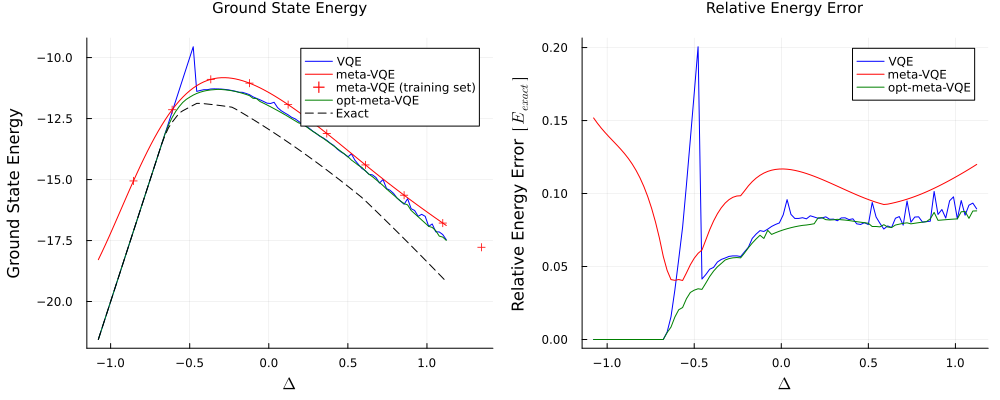

length(Delta_vals) = 100

"s:\\Sync\\University\\20222023_AQA\\AQA_Tut_WorkDir\\mini_project\\plots_and_output\\fig2_abs_energy_and_rel_err_q10.png"

In [18]:
using Plots, StatsPlots
using LaTeXStrings

#Reproducing figure 2 of the meta-vqe paper: Absolute energy and ground state energy as a function of Delta

Delta_vals = [hp[:Delta] for hp in test_set]
@show length(Delta_vals)

l = @layout grid(1,2)

plt_abs_energy = Plots.plot(; title = "Ground State Energy", titleloc = :center, titlefont = font(10), xlabel=L"\Delta", ylabel="Ground State Energy")

vqe_data = JLD.load("./vqe_backup/vqe_q$(nqubits(reg))_test.jld")
vqe_energies = [vqe_data["Delta_$(hp[:Delta])_lambda_$(hp[:lambda])"]["energy_expectation"][end] for hp in test_set] #The [end] is needed because the data was stored incorrectly
Plots.plot!(plt_abs_energy, Delta_vals, vqe_energies; label="VQE", linecolor=:blue)

meta_vqe_data = JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_test.jld")
meta_vqe_energies = [meta_vqe_data["Delta_$(hp[:Delta])_lambda_$(hp[:lambda])"]["energy_expectation"] for hp in test_set] 
Plots.plot!(plt_abs_energy, Delta_vals, meta_vqe_energies; label="meta-VQE", linecolor=:red)
meta_vqe_train_data = JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_train.jld")
meta_vqe_train_energies = [meta_vqe_train_data["Delta_$(hp[:Delta])_lambda_$(hp[:lambda])"]["energy_expectation"] for hp in train_set] 
Plots.scatter!(plt_abs_energy, [hp[:Delta] for hp in train_set], meta_vqe_train_energies; label="meta-VQE (training set)", markershape=:cross, markercolor=:red)

opt_meta_vqe_data = JLD.load("./opt_meta_vqe_backup/opt_meta_vqe_q$(nqubits(reg))_test.jld")
opt_meta_vqe_energies = [opt_meta_vqe_data["Delta_$(hp[:Delta])_lambda_$(hp[:lambda])"]["energy_expectation"][end] for hp in test_set]
Plots.plot!(plt_abs_energy, Delta_vals, opt_meta_vqe_energies; label="opt-meta-VQE", linecolor=:green)

exact_data = JLD.load("./exact_energies_q$(nqubits(reg))_test.jld")
exact_energies = [exact_data["Delta_$(hp[:Delta])_lambda_$(hp[:lambda])"]["energy_expectation"] for hp in test_set]
Plots.plot!(plt_abs_energy, Delta_vals, exact_energies; label="Exact", linestyle=:dash, linecolor=:black)

plt_rel_energy_err = Plots.plot(; title = "Relative Energy Error", titleloc = :center, titlefont = font(10), xlabel=L"\Delta", ylabel=LaTeXString("""Relative Energy Error \$ \\; \\left[ E_{exact} \\right] \$"""), left_margin = 5Plots.mm, bottom_margin = 5Plots.mm, top_margin = 5Plots.mm)

vqe_rel_energy_errors = abs.(exact_energies .- vqe_energies) ./ abs.(exact_energies)
Plots.plot!(Delta_vals, vqe_rel_energy_errors; label="VQE", linecolor=:blue)

meta_vqe_rel_energy_errors = abs.(exact_energies .- meta_vqe_energies) ./ abs.(exact_energies)
Plots.plot!(Delta_vals, meta_vqe_rel_energy_errors; label="meta-VQE", linecolor=:red)

opt_meta_vqe_rel_energy_errors = abs.(exact_energies .- opt_meta_vqe_energies) ./ abs.(exact_energies)
Plots.plot!(Delta_vals, opt_meta_vqe_rel_energy_errors; label="opt-meta-VQE", linecolor=:green)

plt = Plots.plot(plt_abs_energy, plt_rel_energy_err; layout = l, size = (1000, 400), left_margin = 5Plots.mm, bottom_margin = 5Plots.mm, top_margin = 5Plots.mm)
display(plt)
savefig(plt, "./plots_and_output/fig2_abs_energy_and_rel_err_q$(nqubits(reg)).png")


#savefig(plt_rel_energy_err, "./plots_and_output/trail_2_fig4_q$(nqubits(reg)).png" )




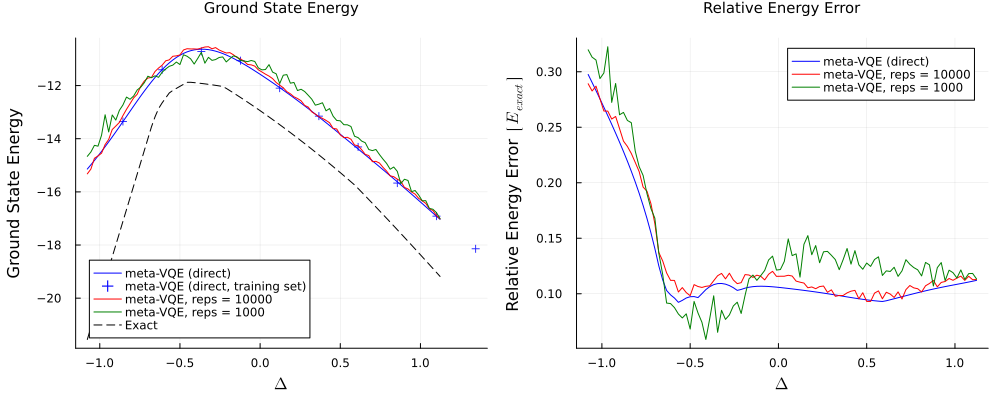

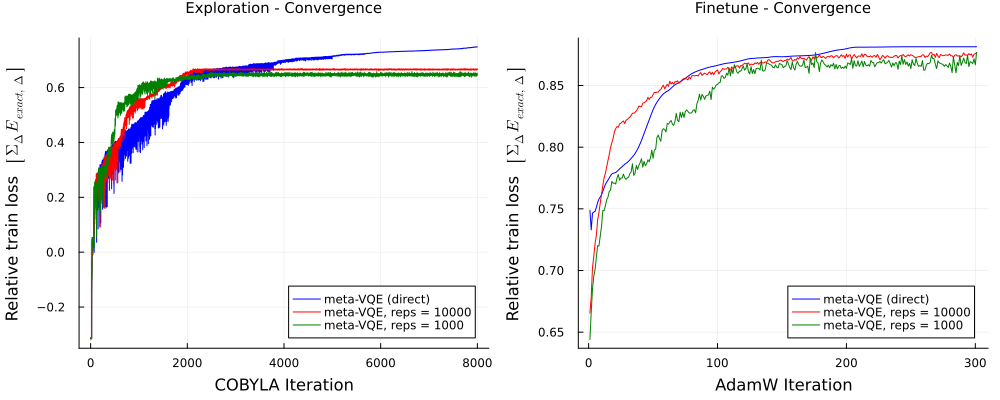

length(Delta_vals) = 100


In [19]:
using Plots, StatsPlots
using LaTeXStrings

#Considering the difference between the meta-VQE with and without sampling noise in ground state energy estimation

Delta_vals = [hp[:Delta] for hp in test_set]
@show length(Delta_vals)

l = @layout grid(1,2)

plt_abs_energy = Plots.plot(; title = "Ground State Energy", titleloc = :center, titlefont = font(10), xlabel=L"\Delta", ylabel="Ground State Energy", legend=:bottomleft)

meta_vqe_direct_data = JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_direct_test.jld")
meta_vqe_direct_energies = [meta_vqe_direct_data["Delta_$(hp[:Delta])_lambda_$(hp[:lambda])"]["energy_expectation"] for hp in test_set] 
Plots.plot!(plt_abs_energy, Delta_vals, meta_vqe_direct_energies; label="meta-VQE (direct)", linecolor=:blue)
meta_vqe_direct_train_data = JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_direct_train.jld")
meta_vqe_direct_train_energies = [meta_vqe_direct_train_data["Delta_$(hp[:Delta])_lambda_$(hp[:lambda])"]["energy_expectation"] for hp in train_set] 
Plots.scatter!(plt_abs_energy, [hp[:Delta] for hp in train_set], meta_vqe_direct_train_energies; label="meta-VQE (direct, training set)", markershape=:cross, markercolor=:blue)

meta_vqe_s10000_data = JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_s10000_test.jld")
meta_vqe_s10000_energies = [meta_vqe_s10000_data["Delta_$(hp[:Delta])_lambda_$(hp[:lambda])"]["energy_expectation"] for hp in test_set] 
Plots.plot!(plt_abs_energy, Delta_vals, meta_vqe_s10000_energies; label="meta-VQE, reps = 10000", linecolor=:red)

meta_vqe_s1000_data = JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_s1000_test.jld")
meta_vqe_s1000_energies = [meta_vqe_s1000_data["Delta_$(hp[:Delta])_lambda_$(hp[:lambda])"]["energy_expectation"] for hp in test_set] 
Plots.plot!(plt_abs_energy, Delta_vals, meta_vqe_s1000_energies; label="meta-VQE, reps = 1000", linecolor=:green)

exact_data = JLD.load("./exact_energies_q$(nqubits(reg))_test.jld")
exact_energies = [exact_data["Delta_$(hp[:Delta])_lambda_$(hp[:lambda])"]["energy_expectation"] for hp in test_set]
Plots.plot!(plt_abs_energy, Delta_vals, exact_energies; label="Exact", linestyle=:dash, linecolor=:black)

plt_rel_energy_err = Plots.plot(; title = "Relative Energy Error", titleloc = :center, titlefont = font(10), xlabel=L"\Delta", ylabel=LaTeXString("""Relative Energy Error \$ \\; \\left[ E_{exact} \\right] \$"""))

meta_vqe_direct_rel_energy_errors = abs.(exact_energies .- meta_vqe_direct_energies) ./ abs.(exact_energies)
Plots.plot!(plt_rel_energy_err, Delta_vals, meta_vqe_direct_rel_energy_errors; label="meta-VQE (direct)", linecolor=:blue)

meta_vqe_s10000_rel_energy_errors = abs.(exact_energies .- meta_vqe_s10000_energies) ./ abs.(exact_energies)
Plots.plot!(plt_rel_energy_err, Delta_vals, meta_vqe_s10000_rel_energy_errors; label="meta-VQE, reps = 10000", linecolor=:red)

meta_vqe_s1000_rel_energy_errors = abs.(exact_energies .- meta_vqe_s1000_energies) ./ abs.(exact_energies)
Plots.plot!(plt_rel_energy_err, Delta_vals, meta_vqe_s1000_rel_energy_errors; label="meta-VQE, reps = 1000", linecolor=:green)

plt = Plots.plot(plt_abs_energy, plt_rel_energy_err; layout = l, size = (1000, 400), left_margin = 5Plots.mm, bottom_margin = 5Plots.mm, top_margin = 5Plots.mm)

display(plt)
savefig(plt, "./plots_and_output/sampling_noise_abs_energy_and_rel_error_q$(nqubits(reg)).png" )

# ----------------------------------------------

exact_train_loss = sum(JLD.load("./exact_energies_q$(nqubits(reg))_train.jld")["exact_energies"])
tot_optim_iterations = length(JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_optim_circuit_params_direct.jld", "loss_trace"))

l = @layout grid(1,2)

plt_err_converge_explor = Plots.plot(; title = "Exploration - Convergence", titleloc = :center, titlefont = font(10), xlabel="COBYLA Iteration", ylabel=LaTeXString("""Relative train loss  \$ \\; \\left[ \\Sigma_{\\Delta} E_{exact, \\; \\Delta} \\right] \$"""), left_margin = 5Plots.mm, bottom_margin = 5Plots.mm, top_margin = 5Plots.mm)

meta_vqe_direct_converge_data = JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_optim_circuit_params_direct.jld", "loss_trace")
meta_vqe_direct_rel_explor_losses = meta_vqe_direct_converge_data[1:8000] ./ exact_train_loss
Plots.plot!(1:8000, meta_vqe_direct_rel_explor_losses; label="meta-VQE (direct)", linecolor=:blue)


meta_vqe_s10000_converge_data = JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_optim_circuit_params_s10000.jld", "loss_trace")
meta_vqe_s10000_rel_explor_losses = meta_vqe_s10000_converge_data[1:8000] ./ exact_train_loss
Plots.plot!(1:8000, meta_vqe_s10000_rel_explor_losses; label="meta-VQE, reps = 10000", linecolor=:red)

meta_vqe_s1000_converge_data = JLD.load("./meta_vqe_backup/meta_vqe_q$(nqubits(reg))_optim_circuit_params_s1000.jld", "loss_trace")
meta_vqe_s1000_rel_explor_losses = meta_vqe_s1000_converge_data[1:8000] ./ exact_train_loss
Plots.plot!(1:8000, meta_vqe_s1000_rel_explor_losses; label="meta-VQE, reps = 1000", linecolor=:green)

plt_err_converge_finetune = Plots.plot(; title = "Finetune - Convergence", titleloc = :center, titlefont = font(10), xlabel="AdamW Iteration", ylabel=LaTeXString("""Relative train loss  \$ \\; \\left[ \\Sigma_{\\Delta} E_{exact, \\; \\Delta} \\right] \$"""), left_margin = 5Plots.mm, bottom_margin = 5Plots.mm, top_margin = 5Plots.mm)

meta_vqe_direct_rel_finetune_losses = meta_vqe_direct_converge_data[8001:end] ./ exact_train_loss
Plots.plot!(plt_err_converge_finetune, 1:(tot_optim_iterations-8000), meta_vqe_direct_rel_finetune_losses; label="meta-VQE (direct)", linecolor=:blue)

meta_vqe_s10000_rel_finetune_losses = meta_vqe_s10000_converge_data[8001:end] ./ exact_train_loss
Plots.plot!(plt_err_converge_finetune, 1:(tot_optim_iterations-8000), meta_vqe_s10000_rel_finetune_losses; label="meta-VQE, reps = 10000",  linecolor=:red)

meta_vqe_s1000_rel_finetune_losses = meta_vqe_s1000_converge_data[8001:end] ./ exact_train_loss
Plots.plot!(plt_err_converge_finetune, 1:(tot_optim_iterations-8000), meta_vqe_s1000_rel_finetune_losses; label="meta-VQE, reps = 1000", linecolor=:green)

plt = Plots.plot(plt_err_converge_explor, plt_err_converge_finetune; layout = l, size = (1000, 400), left_margin = 5Plots.mm, bottom_margin = 5Plots.mm, top_margin = 5Plots.mm)

savefig(plt, "./plots_and_output/sampling_noise_convergence_q$(nqubits(reg)).png" )
display(plt)
